# Part D: Introduction

In the final part we have to find a classifier that perform well on an unknown testing set. In order to do we have select a model that performs the best at the training dataset we have and ensure that it generalizes.

**Cross Validation and Nested Cross Validation**

 A good practice it to perform cross-validation on the training set, try various models with various parameters, and select the model with the best cross validation accuracy. The problem with this method is that to some extend there is still data leakage into training and we dont have an estimate for the generelization error. For example since we try a lot of models, we increase the chances that a model just happened to perform well on the validation set, since by performing hyperparameter tuning we try to find a model that performs well on the validation set

 An effective way to have an estimate of the generalization error is to use nested cross validation. Essentialy that means we have an outer loop where we have n-folds of training and testing sets. And in each fold, in the training set we perform cross validation again and the evaluate the performance of the model on the test set of the outer loop. In the end we report the average accuracy on the testing sets

 Nested cross validation is used for model selection NOT for hyperparameter tuning. After we have selected a model we can perform cross validation on the entire training set again to find the best set of hyperparameters for the specific model

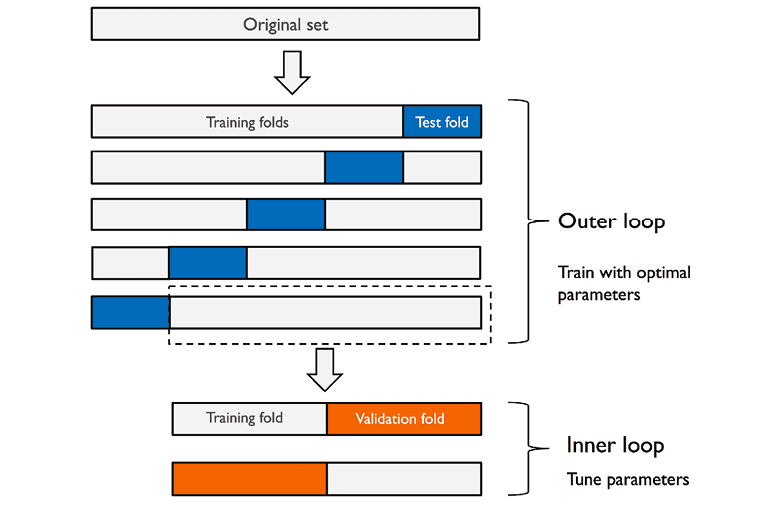

**Bayesian Optimization**


Bayesian optimization is a sequential strategy for the global optimization of black-box functions that are expensive to evaluate and do not assume any functional forms. It treats the objective function as a random function and uses a prior to capture beliefs about the behavior of the function. The prior is updated to a posterior distribution after function evaluations, which then informs the next query point. The black box functions in our case are the classifiers and as metric the accuracy of 5-fold cross validation will be used. For its implementation, we utilized the scikit-optimize library, which is a Python tool for performing this kind of optimization.

In [ ]:
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git

  Cloning https://github.com/scikit-optimize/scikit-optimize.git to /tmp/pip-req-build-n0ichwle
  Running command git clone --filter=blob:none --quiet https://github.com/scikit-optimize/scikit-optimize.git /tmp/pip-req-build-n0ichwle
  Resolved https://github.com/scikit-optimize/scikit-optimize.git to commit a2369ddbc332d16d8ff173b12404b03fea472492
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pyaml-23.12.0-py3-none-any.whl (23 kB)
  Created wheel for scikit-optimize: filename=scikit_optimize-0.9.0-py2.py3-none-any.whl size=100246 sha256=33852725f4a6de38e6949998bfb16876edfccab09a8e58322ce18718b45e1488
  Stored in directory: /tmp/pip-ephem-wheel-cache-i0ncmpcx/wheels/2f/f0/ed/db529a96372d05bd34f6c3a2fa7c08ef7a8314315ac46e49d7
Successfully built scikit-optimize


**Ensembles**



Ensemble methods in machine learning combine multiple models to improve predictive performance, leveraging the strengths of various algorithms. The intuition behind ensembles is that combining diverse models can reduce errors, enhance accuracy, and handle overfitting more effectively than single models.

* Boosting: A sequential technique where each model attempts to correct the errors of its predecessor, typically leading to strong predictive performance. In boosting, particularly in methods like AdaBoost and Gradient Boosting, the same type of model, often decision trees, is typically used. These trees are usually shallow, meaning they are not deeply grown, which helps in sequentially correcting the errors of the previous trees and improving the overall model's performance. This approach leverages the strengths of simple models to create a more powerful and accurate composite model.
* Voting: Involves multiple models, each voting on the prediction. The final prediction is typically based on the majority or average vote.
* Stacking: Combines various models' predictions and uses a second-level model (meta-learner) to make the final prediction, based on the predictions from the previous models. Usually an out-of-sample dataset is used to train the meta model. That means cross validation is performed on the training set and the predictions of the base models in each validation fold is used as training for the

It should be noted since in order to avoid complexity and since stacking models already use cross validation, we didnt include a third cross validation loop



# Part D: Experiments

In the following code cells we have the code for bayesian optimization of the various models we tried. There are different cells because different colab instances were used to run the code in order to "parallelize" the execution. The final model we used was the one with the best performance on the outer loops, the stacking classifier that used as a meta classifier a soft voting classifier.

Some techniques that were used but led to no better performances are not include in this, like scaling the data and using PCA or t-SNE to reduce dimensionality

**SVM**

Average accuracy on the outer loops: 0.8414

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import numpy as np
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Load your dataset
file_path = 'datasetC.csv'
data = np.loadtxt(file_path, delimiter=",", dtype=np.float64)
X = data[:, :-1]
y = data[:, -1]
y -= np.min(y)

# Outer K-Fold Cross-Validation
outer_cv = KFold(n_splits=2, shuffle=True, random_state=42)
outer_scores = []

counter = 0
for train_idx, test_idx in outer_cv.split(X):
    print(f'Current Split: {counter}')
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Define the pipeline
    pipe = Pipeline([
        ('model', SVC())
    ])

    # Define the parameter search space
    svc_search = {
        'model': Categorical([SVC()]),
        'model__C': Real(1e-6, 1e+6, prior='log-uniform'),
        'model__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
        'model__degree': Integer(1, 8),
        'model__kernel': Categorical(['poly', 'rbf']),
    }

    # Bayesian optimization
    opt = BayesSearchCV(
        pipe,
        [(svc_search, 40)],
        cv=5,
        n_jobs = -1
    )

    opt.fit(X_train, y_train)

    # Evaluate on the test set of the outer fold
    test_score = opt.score(X_test, y_test)
    outer_scores.append(test_score)
    print(f"Fold Test Score: {test_score}")
    print(f"Best params: {opt.best_params_}")

    counter+=1
# Report the average accuracy across outer folds
average_score = np.mean(outer_scores)
print(f"Average Test Score across Outer Folds: {average_score}")

**AdaBoost**

Average Accuracy: 0.71

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Load your dataset
file_path = 'datasetC.csv'
data = np.loadtxt(file_path, delimiter=",", dtype=np.float64)
X = data[:, :-1]
y = data[:, -1]
y -= np.min(y)

# Outer K-Fold Cross-Validation
outer_cv = KFold(n_splits=2, shuffle=True, random_state=42)
outer_scores = []

for train_idx, test_idx in outer_cv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Define the pipeline
    pipe = Pipeline([
        ('model', AdaBoostClassifier())
    ])

    # Define the parameter search space for AdaBoost
    adaboost_search = {
        'model': [AdaBoostClassifier()],
        'model__n_estimators': Integer(50, 500),
        'model__learning_rate': Real(0.01, 1, prior='log-uniform')
    }

    # Bayesian optimization
    opt = BayesSearchCV(
        pipe,
        [(adaboost_search, 40)],  # Number of iterations for Bayesian optimization
        cv=5  # Inner cross-validation
    )

    opt.fit(X_train, y_train)

    # Evaluate on the test set of the outer fold
    test_score = opt.score(X_test, y_test)
    outer_scores.append(test_score)
    print(f"Fold Test Score: {test_score}")
    print(f"Best params: {opt.best_params_}")

# Report the average accuracy across outer folds
average_score = np.mean(outer_scores)
print(f"Average Test Score across Outer Folds: {average_score}")

**XGBoost**

Average accuracy on the outer loops: 0.7544

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Load your dataset
file_path = 'datasetC.csv'
data = np.loadtxt(file_path, delimiter=",", dtype=np.float64)
X = data[:, :-1]
y = data[:, -1]
y -= np.min(y)

# Outer K-Fold Cross-Validation
outer_cv = KFold(n_splits=2, shuffle=True, random_state=42)
outer_scores = []

for train_idx, test_idx in outer_cv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Define the pipeline
    pipe = Pipeline([
        ('model', xgb.XGBClassifier())
    ])

    # Define the parameter search space for XGBoost
    xgb_search = {
        'model': [xgb.XGBClassifier(tree_method='hist')],
        'model__max_depth': Integer(3, 10),
        'model__min_child_weight': Real(1, 10),
        'model__subsample': Real(0.5, 1.0)
    }

    # Bayesian optimization
    opt = BayesSearchCV(
        pipe,
        [(xgb_search, 40)],
        cv=5
    )

    opt.fit(X_train, y_train)

    # Evaluate on the test set of the outer fold
    test_score = opt.score(X_test, y_test)
    outer_scores.append(test_score)
    print(f"Fold Test Score: {test_score}")
    print(f"Best params: {opt.best_params_}")

# Report the average accuracy across outer folds
average_score = np.mean(outer_scores)
print(f"Average Test Score across Outer Folds: {average_score}")

**MLP**

Average Accuracy: 0.8

In [ ]:
# Imports (removed duplicates)
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neural_network import MLPClassifier
import numpy as np
import time

# Load dataset
file_path = 'datasetC.csv'  # Update the path as needed
data = np.loadtxt(file_path, delimiter=",", dtype=np.float64)
X, y = data[:, :-1], data[:, -1] - np.min(data[:, -1])
X = X.astype(np.float32)
y = y.astype(np.int64)

# Define grid search parameters for MLPClassifier
mlp_grid_params = {
    'hidden_layer_sizes': [(32, 16), (64,), (100,25), (256, 128, 64), (200,100)],
    'alpha': [0.0001, 0.001, 0.01, 1, 1e-5],
    'activation': ['relu', 'tanh'],
    'solver': ['sgd', 'adam']
}

# Initialize the MLPClassifier
mlp = MLPClassifier(max_iter=500, batch_size=128, early_stopping=True)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=mlp_grid_params,
    cv=5,  # Inner cross-validation
    n_jobs=-1,  # Use all available CPU cores
    scoring='accuracy'  # Use accuracy for evaluation
)

# Outer K-Fold Cross-Validation setup
outer_cv = KFold(n_splits=2, shuffle=True, random_state=42)
outer_scores = []

# Iterate through outer folds
for train_idx, test_idx in outer_cv.split(X):
    start_time = time.time()

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Fit the grid search
    grid_search.fit(X_train, y_train)

    # Evaluate on the test set
    test_score = grid_search.score(X_test, y_test)
    outer_scores.append(test_score)

    end_time = time.time()  # End time measurement
    duration = end_time - start_time  # Calculate duration
    minutes = int(duration // 60)
    seconds = int(duration % 60)

    print(f"Outer Fold Test Score: {test_score}")
    print(f"Time taken for this fold: {minutes} minutes and {seconds} seconds\n")

# Report the average score across folds
average_score_across_outer_folds = np.mean(outer_scores)
print(f"Average Test Score across Outer Folds: {average_score_across_outer_folds}")






**1d-CNN**

Average Accuracy: 0.83

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jan  4 19:50:31 2024

@author: Paschalis
"""

import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold

# Define a simple 1D Convolutional Neural Network
class Conv1dNet(nn.Module):
    def __init__(self, channels_first = 32, channels_second = 16):
        super(Conv1dNet, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=channels_first, kernel_size=3, stride=1, padding=1)
        # Second convolutional layer
        self.conv2 = nn.Conv1d(in_channels=channels_first, out_channels=channels_second, kernel_size=3, stride=1, padding=1)
        # Activation function
        self.relu = nn.ReLU()
        # Pooling layer
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        # Dropout layer
        self.dropout = nn.Dropout(0.5)
        # Fully connected layer, adjust output size to 5 for 5 classes
        # Correcting the input dimension to the fully connected layer
        self.fc = nn.Linear(channels_second * 200, 5)  # Adjusted for second conv layer and 5 output classes

        #self.fc = nn.Linear(channels_second * 25, int((channels_second * 25)/2))  # Adjusted for second conv layer and 5 output classes
        #self.fc2 = nn.Linear(int((channels_second * 25)/2), 5)

    def forward(self, x):
        x = self.conv1(x)
        #print(x.shape)
        x = self.relu(x)
        x = self.conv2(x)
        #print(x.shape)
        x = self.relu(x)
        x = self.pool(x)
        #print(x.shape)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        #print(x.shape)
        x = self.fc(x)
        #x = self.relu(x)
        #x = self.dropout(x)
        #x = self.fc2(x)
        return x

model = Conv1dNet(channels_first = 4, channels_second = 2)

input_tensor = torch.randn(1, 1, 400)
with torch.no_grad():
    output = model(input_tensor)
    print(output.shape)


# Training function
def train_network(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            # Reshape inputs for Conv1d
            inputs = inputs.unsqueeze(1)
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        #print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Evaluation function
def evaluate_network(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

def inner_cv_train_evaluate(model_class, X_train, y_train, channels_first, channels_second):
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    inner_accuracies = []

    for train_idx, val_idx in inner_cv.split(X_train):
        X_train_cv, X_val_cv = X_train[train_idx], X_train[val_idx]
        y_train_cv, y_val_cv = y_train[train_idx], y_train[val_idx]

        train_loader_cv = DataLoader(TensorDataset(torch.tensor(X_train_cv, dtype=torch.float32), torch.tensor(y_train_cv, dtype=torch.long)), batch_size=100, shuffle=True)
        val_loader_cv = DataLoader(TensorDataset(torch.tensor(X_val_cv, dtype=torch.float32), torch.tensor(y_val_cv, dtype=torch.long)), batch_size=100)

        model = model_class(channels_first=channels_first, channels_second=channels_second)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        train_network(model, train_loader_cv, criterion, optimizer, epochs=20)
        accuracy = evaluate_network(model, val_loader_cv)
        inner_accuracies.append(accuracy)

    return np.mean(inner_accuracies)



# Load your dataset
file_path = 'datasetC.csv'
data = np.loadtxt(file_path, delimiter=",", dtype=np.float64)
X = data[:, :-1]
y = data[:, -1]
# Convert to PyTorch tensors
#X = torch.tensor(X, dtype=torch.float32)
#y = torch.tensor(y, dtype=torch.long)
y -= np.min(y)

# Define the parameter grid for the grid search
channels_first_options = [4, 16, 32]
channels_second_options = [2, 4, 16]


# Initialize KFold for outer cross-validation
outer_cv = KFold(n_splits=2, shuffle=True, random_state=42)

# Placeholder for scores from each outer fold
outer_scores = []

# Outer cross-validation loop
for train_idx, test_idx in outer_cv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)), batch_size=100, shuffle=True)

    # Convert to PyTorch tensors and create data loaders
    #train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)), batch_size=100, shuffle=True)
    #val_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)), batch_size=100)

    best_accuracy = 0
    best_params = None

    # Grid search loop

    for channels_first in channels_first_options:
        for channels_second in channels_second_options:

            model = Conv1dNet(channels_first = channels_first, channels_second = channels_second)

            inner_accuracy  = inner_cv_train_evaluate(Conv1dNet, X_train, y_train, channels_first, channels_second)

            if inner_accuracy > best_accuracy:
                best_accuracy = inner_accuracy
                best_params = (channels_first, channels_second)

    val_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)), batch_size=100)
    best_model = Conv1dNet(channels_first=best_params[0], channels_second=best_params[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(best_model.parameters(), lr=0.001)
    train_network(best_model, train_loader, criterion, optimizer, epochs=20)
    test_accuracy = evaluate_network(best_model, val_loader)

    outer_scores.append(test_accuracy)
    print(f"Best parameters for this fold: {best_params}, Test Accuracy: {test_accuracy}")

# Calculate and print the average accuracy across all folds
average_accuracy = np.mean(outer_scores)
print(f"Average accuracy across all folds: {average_accuracy}")

**Stacking**

In the final stacking model, we used 10 base models and a meta classifier a soft voting classifier consisting of an SVM, MLP, XGBboost and AdaBoost.
Stuff the we tried:
* Fine tuning the base models: It increase time complexity exponentialy. A few trials showed no improvement so no further effort was put into fine tuning the base models
* Use various classifiers as a meta estimator: Changing the meta classifier and fine tuning it led to improved performance but a meta classifier with soft voting gave the best results. Fine tuning the models of the voting classifiers also didnt provide any better results.

In [ ]:
# -*- coding: utf-8 -*-
import torch.nn as nn
import torch.nn.functional as F
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.preprocessing import LabelEncoder
import numpy as np

class GaussianBayesClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, use_same_cov=True):
        self.use_same_cov = use_same_cov

    def fit(self, X, y):
        self.label_encoder_ = LabelEncoder()
        X, y = check_X_y(X, y)
        encoded_y = self.label_encoder_.fit_transform(y)

        self.classes_ = self.label_encoder_.classes_

        classes = np.unique(encoded_y)
        class_freq = {}
        means = {}
        self.cov_inv_ = None
        self.cov_matrices_ = {}

        if self.use_same_cov:
            cov_matrix_all_data = np.cov(X, rowvar=False)
            self.cov_inv_ = np.linalg.inv(cov_matrix_all_data)
            for label in classes:
                subset = X[encoded_y == label]
                class_freq[label] = len(subset) / len(X)
                means[label] = np.mean(subset, axis=0).reshape(-1,1)
        else:
            for label in classes:
                subset = X[encoded_y == label]
                class_freq[label] = len(subset) / len(X)
                self.cov_matrices_[label] = np.cov(subset, rowvar=False)
                means[label] = np.mean(subset, axis=0).reshape(-1,1)

        self.class_freq_ = class_freq
        self.means_ = means

        return self

    def predict(self, X):
        check_is_fitted(self, ['means_', 'cov_inv_', 'cov_matrices_'])
        X = check_array(X)

        x = np.transpose(X)
        g = []

        if self.use_same_cov is True:
            for label in self.classes_:
                class_ind = int(label)
                if self.class_freq_[class_ind] == 0:
                    continue
                w_i = self.cov_inv_ @ self.means_[class_ind]
                b_i = -0.5 * np.transpose(self.means_[class_ind]) @ self.cov_inv_ @ self.means_[class_ind] + np.log(self.class_freq_[class_ind])
                g.append(np.transpose(w_i) @ x + b_i)
        else:
            for label in self.classes_:
                class_ind = int(label)
                if self.class_freq_[class_ind] == 0:
                    continue
                cov = self.cov_matrices_[class_ind]
                cov_inv = np.linalg.inv(cov)
                W_i = -0.5 * cov_inv
                w_i = cov_inv @ self.means_[class_ind]
                b_i = -0.5 * np.transpose(self.means_[class_ind]) @ cov_inv @ self.means_[class_ind] - 0.5 * np.log(np.linalg.det(cov)) + np.log(self.class_freq_[class_ind])
                quad_vect = np.einsum('ij,ij->j', np.matmul(W_i, x), x)
                g.append(quad_vect + np.transpose(w_i) @ x + b_i)

        if len(g) == 0:
            raise ValueError("No classes from the training set are present in the test set.")

        g = np.row_stack(g)
        y_pred = np.argmax(g, axis=0)
        y_pred = self.label_encoder_.inverse_transform(y_pred)

        return y_pred

    def predict_proba(self, X):
        # Check if fit has been called
        check_is_fitted(self, ['means_', 'cov_inv_', 'cov_matrices_'])
        X = check_array(X)

        x = np.transpose(X)
        g = []

        if self.use_same_cov is True:
            for label in self.classes_:
                class_ind = int(label)
                if self.class_freq_[class_ind] == 0:
                    continue
                w_i = self.cov_inv_ @ self.means_[class_ind]
                b_i = -0.5 * np.transpose(self.means_[class_ind]) @ self.cov_inv_ @ self.means_[class_ind] + np.log(self.class_freq_[class_ind])
                g.append(np.transpose(w_i) @ x + b_i)
        else:
            for label in self.classes_:
                class_ind = int(label)
                if self.class_freq_[class_ind] == 0:
                    continue
                cov = self.cov_matrices_[class_ind]
                cov_inv = np.linalg.inv(cov)
                W_i = -0.5 * cov_inv
                w_i = cov_inv @ self.means_[class_ind]
                b_i = -0.5 * np.transpose(self.means_[class_ind]) @ cov_inv @ self.means_[class_ind] - 0.5 * np.log(np.linalg.det(cov)) + np.log(self.class_freq_[class_ind])
                quad_vect = np.einsum('ij,ij->j', np.matmul(W_i, x), x)
                g.append(quad_vect + np.transpose(w_i) @ x + b_i)

        if len(g) == 0:
            raise ValueError("No classes from the training set are present in the test set.")

        g = np.row_stack(g)
        g_values = np.transpose(g)
        exp_g = np.exp(g_values - np.max(g_values, axis=1, keepdims=True))  # Numerical stability
        probabilities = exp_g / np.sum(exp_g, axis=1, keepdims=True)


        return probabilities

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import StackingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import numpy as np
import time
from itertools import product
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
import time
from itertools import product
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
import time

# Define the model parameters
# We only kept the final model parameters. If more parameters are added, model lists
#for each parameter set will be generated in order to perform grid search
base_models_params = {
    'SVM1': {
        'model': SVC,
        'params': {'probability': [True], 'kernel': ['rbf'], 'C': [1], 'gamma': ['scale']}
    },
    'SVM2': {
        'model': SVC,
        'params': {'probability': [True], 'kernel': ['poly'], 'degree': [2], 'C': [0.81], 'gamma': [0.034]}
    },
    'KNN1': {
        'model': KNeighborsClassifier,
        'params': {'n_neighbors': [1]}
    },
    'KNN5': {
        'model': KNeighborsClassifier,
        'params': {'n_neighbors': [5]}
    },

    'KNN25': {
        'model': KNeighborsClassifier,
        'params': {'n_neighbors': [25]}
    },

    'KNN100': {
        'model': KNeighborsClassifier,
        'params': {'n_neighbors': [100]}
    },

    'MLP': {
        'model': MLPClassifier,
        'params': [
            {'hidden_layer_sizes': (64, 32), 'activation': 'relu'},
        ]
    },
    'RandomForest': {
        'model': RandomForestClassifier,
        'params': {
            'max_depth': [10]
        }
    },
    'HistGradientBoosting': {
        'model': HistGradientBoostingClassifier,
        'params': {
            'max_depth': [10],
        }
    },
    'GauBayes': {
        'model': GaussianBayesClassifier,
        'params': [{'use_same_cov': True}]
    }
    # Add other models and parameters here if needed
}

# Function to generate all model instances for a given set of parameters
def generate_model_instances(model_class, params):
    if isinstance(params, list):
        return [model_class(**param) for param in params]
    else:
        keys, values = zip(*params.items())
        return [model_class(**dict(zip(keys, v))) for v in product(*values)]

# Generate all combinations of base models
base_models_combinations = []

for model_name, model_info in base_models_params.items():
    model_instances = generate_model_instances(model_info['model'], model_info['params'])
    base_models_combinations.append((model_name, model_instances))

# Now, create lists of models for stacking
stacking_model_lists = []

for combination in product(*[model_info[1] for model_info in base_models_combinations]):
    model_list = [(base_models_combinations[i][0], model) for i, model in enumerate(combination)]
    stacking_model_lists.append(model_list)


# Load dataset
file_path = 'datasetC.csv'
data = np.loadtxt(file_path, delimiter=",", dtype=np.float64)
X, y = data[:, :-1], data[:, -1] - np.min(data[:, -1])
X = X.astype(np.float32)
y = y.astype(np.int64)

# First model list from stacking_model_lists
model_list = stacking_model_lists[0]  # Assuming stacking_model_lists is defined

# Meta models for voting classifier
meta_xgb = xgb.XGBClassifier(tree_method="hist", device='cpu')
meta_mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.001)
meta_adaboost = AdaBoostClassifier()
meta_SVM = SVC(probability = True)

# Soft Voting Classifier
soft_voting_clf = VotingClassifier(
    estimators=[
        ('xgb', meta_xgb),
        ('mlp', meta_mlp),
        ('adaboost', meta_adaboost),
        ('svm', meta_SVM)
    ],
    voting='soft'
)

# Outer K-Fold Cross-Validation setup
outer_cv = KFold(n_splits=2, shuffle=True, random_state=42)

# Iterate through outer folds
outer_scores = []
for train_idx, test_idx in outer_cv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    start_time = time.time()

    # Define the stacking classifier with soft voting as meta classifier
    stacking_clf = StackingClassifier(estimators=model_list, final_estimator=soft_voting_clf)

    # Perform 5-fold cross-validation on the training data of the outer fold
    cv_scores = cross_val_score(stacking_clf, X_train, y_train, cv=5, n_jobs=-1)
    average_cv_score = np.mean(cv_scores)
    outer_scores.append(average_cv_score)

    end_time = time.time()  # End time measurement
    duration = end_time - start_time  # Calculate duration

    minutes = int(duration // 60)
    seconds = int(duration % 60)

    print(f"Outer Fold Average CV Accuracy: {average_cv_score}")
    print(f"Time taken for this fold: {minutes} minutes and {seconds} seconds\n")

# Report the average accuracy across outer folds
average_score_across_outer_folds = np.mean(outer_scores)
print(f"Average Accuracy across Outer Folds: {average_score_across_outer_folds}")


Outer Fold Average CV Accuracy: 0.8564
Time taken for this fold: 18 minutes and 49 seconds

Outer Fold Average CV Accuracy: 0.8684
Time taken for this fold: 19 minutes and 9 seconds

Average Accuracy across Outer Folds: 0.8624


# Fit final model

In [ ]:
stacking_clf_final = StackingClassifier(estimators=model_list, final_estimator=soft_voting_clf)
stacking_clf_final.fit(X,y)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


StackingClassifier(estimators=[('SVM1', SVC(C=1, probability=True)),
                               ('SVM2',
                                SVC(C=0.81, degree=2, gamma=0.034,
                                    kernel='poly', probability=True)),
                               ('KNN1', KNeighborsClassifier(n_neighbors=1)),
                               ('KNN5', KNeighborsClassifier()),
                               ('KNN25', KNeighborsClassifier(n_neighbors=25)),
                               ('KNN100',
                                KNeighborsClassifier(n_neighbors=100)),
                               ('MLP',
                                MLPClassifier(hidden_layer_size...
                                                                               max_cat_threshold=None,
                                                                               max_cat_to_onehot=None,
                                                                               max_delta_step=None,
                                                                               max_depth=None,
                                                                               max_leaves=None,
                                                                               min_child_weight=None,
                                                                               missing=nan,
                                                                               monotone_constraints=None,
                                                                               multi_strategy=None,
                                                                               n_estimators=None,
                                                                               n_jobs=None,
                                                                               num_parallel_tree=None,
                                                                               random_state=None, ...)),
                                                                ('mlp',
                                                                 MLPClassifier(alpha=0.001)),
                                                                ('adaboost',
                                                                 AdaBoostClassifier()),
                                                                ('svm',
                                                                 SVC(probability=True))],
                                                    voting='soft'))

In [ ]:
file_path = 'datasetCTest.csv'
dataTest = np.loadtxt(file_path, delimiter=",", dtype=np.float64)
XTest =  dataTest
XTest = XTest.astype(np.float32)
y_pred = stacking_clf_final.predict(XTest)



In [ ]:
print(y_pred.shape)
y_pred_final = y_pred+1
print(y_pred_final)

(1000,)
[5 2 4 1 5 1 2 4 3 4 3 5 1 2 1 5 5 3 5 1 4 5 5 1 1 2 2 3 2 2 2 2 2 1 2 2 3
 5 3 3 1 2 2 4 4 2 1 5 2 4 3 2 1 2 1 3 2 1 2 4 1 1 3 2 1 3 3 1 3 4 1 4 5 1
 1 2 4 3 5 1 1 5 4 4 1 3 5 4 5 2 4 2 3 3 2 4 3 2 4 3 4 1 1 4 5 5 2 4 3 2 5
 5 1 4 5 3 2 5 3 4 2 1 1 1 4 5 3 2 5 2 1 5 5 1 4 1 2 1 4 2 4 4 2 4 3 5 2 1
 4 2 3 1 2 3 3 3 4 5 4 1 1 1 2 3 4 4 5 2 3 1 1 1 2 2 3 5 4 5 1 1 5 5 3 3 4
 3 4 5 1 3 5 3 2 3 3 2 1 2 3 1 3 1 2 1 3 3 5 2 3 5 4 5 2 4 5 1 1 5 3 3 1 1
 4 4 4 2 5 3 4 1 3 2 2 2 3 4 4 5 3 4 2 5 1 2 4 5 1 5 3 2 1 1 3 4 4 2 3 2 2
 5 1 5 1 5 1 5 4 2 1 1 4 4 1 1 5 2 1 3 2 4 2 5 1 1 2 2 3 5 4 5 4 3 1 1 2 3
 3 4 3 5 4 1 2 4 2 5 1 4 1 2 4 4 4 3 4 1 4 4 4 4 5 3 5 1 3 2 1 5 1 5 3 1 3
 1 4 2 1 1 3 3 3 4 2 5 1 1 2 2 4 1 4 4 3 2 5 5 4 4 1 1 2 1 2 4 3 3 3 2 4 2
 5 1 5 3 3 5 5 5 3 4 3 3 5 3 2 4 4 3 2 5 4 2 5 1 2 3 4 5 3 5 2 1 5 2 3 4 5
 4 5 5 1 3 2 3 3 4 3 5 4 1 1 1 4 2 3 4 2 4 4 1 3 1 4 4 5 5 3 5 1 3 3 5 1 1
 3 4 5 1 5 3 1 2 4 3 3 5 5 1 4 4 1 4 2 3 1 4 1 4 2 1 4 5 2 4 5 2 1 2 4 3 5
 2 5 2 4 5 2 4 3 

In [ ]:
np.save('labelsX.npy', y_pred_final)